In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
#from sklearn.calibration import CalibratedClassifierCV
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train_df_raw, val_df_raw = train_test_split(df, test_size=0.2, random_state=42)

def get_safe_survival_mapping(train_fs, test_fs):
    train_fs = train_fs.copy()
    test_fs = test_fs.copy()

    for df in [train_fs, test_fs]:
        df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
        df['Is_Adult_Male'] = df['Name'].str.contains('Mr\.').astype(int)
        
    train_fs['Family_Survival'] = 2
    test_fs['Family_Survival'] = 2

    for _, group in train_fs.groupby(['Surname', 'Fare']):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if row['Is_Adult_Male'] == 1:
                    train_fs.loc[ind, 'Family_Survival'] = 0
                else:
                    others = group.drop(ind)
                    if others['Survived'].max() == 1.0:
                        train_fs.loc[ind, 'Family_Survival'] = 1
                    elif others['Survived'].max() == 0.0:
                        train_fs.loc[ind, 'Family_Survival'] = 0
    for _, group in train_fs.groupby('Ticket'):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if train_fs.loc[ind, 'Family_Survival'] == 2:
                    if row['Is_Adult_Male'] == 1:
                        train_fs.loc[ind, 'Family_Survival'] = 0
                    else: 
                        others = group.drop(ind)
                        if others['Survived'].max() == 1.0:
                            train_fs.loc[ind, 'Family_Survival'] = 1
                        elif others['Survived'].max() == 0.0:
                            train_fs.loc[ind, 'Family_Survival'] = 0

    for ind, row in test_fs.iterrows():
        if row['Is_Adult_Male'] == 1:
            test_fs.loc[ind, 'Family_Survival'] = 0
            continue
        fam_in_train = train_fs[(train_fs['Surname'] == row['Surname']) & (train_fs['Fare'] == row['Fare'])]
        ticket_in_train = train_fs[train_fs['Ticket'] == row['Ticket']]

        combined = pd.concat([fam_in_train, ticket_in_train])

        if len(combined) > 0:
            if combined['Survived'].max() == 1.0:
                test_fs.loc[ind, 'Family_Survival'] = 1
            elif combined['Survived'].max() == 0.0:
                test_fs.loc[ind, 'Family_Survival'] = 0

    full_mapping = pd.concat([train_fs[['PassengerId', 'Family_Survival']],
                                    test_fs[['PassengerId', 'Family_Survival']]])
    return full_mapping

def fill_missing_fare(df):
    return df.groupby(['Pclass', 'Embarked'])['Fare_Individual'].transform(lambda x: x.fillna(x.median()))

def prepare_data(df_input, survival_mapping):
    df = df_input.copy()
    
    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    df = df.merge(survival_mapping, on='PassengerId', how='left')
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Service')
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Lady', 'Countess', 'Dona'], 'Noble')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Officer')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    df['Fare_Individual'] = df['Fare'] / df['Ticket_Group_Size']
    df['Fare_Individual'] = fill_missing_fare(df)
    df['IsFreeTicket'] = (df['Fare'] == 0)
    df['IsChild'] = df['Age'] < 14
    df['IsOld'] = df['Age'] > 60
    df['IsWoman'] = df['Sex'] == 'female'
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilySizeBin'] = df['FamilySize'].apply(lambda x: 'Alone' if x == 1 else ('Small' if 2 <= x <= 4 else 'Large'))
    df['IsAlone'] = (df['FamilySize'] == 1)
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    deck_mapping = {
    'B': 0.74, 'D': 0.75, 'E': 0.75,
    'C': 0.59,                      
    'A': 0.50, 'T': 0.50,           
    'F': 0.61, 'G': 0.40,           
    'M': 0.23                       
    }
    df['Deck_Score'] = df['Deck'].map(deck_mapping)
    df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
    df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    df = pd.get_dummies(df, columns=['Title', 'FamilySizeBin', 'Deck', 'Embarked'])
    
    return df.astype(float)

fs_map = get_safe_survival_mapping(train_df_raw, val_df_raw)

X_train = prepare_data(train_df_raw, fs_map).drop(columns=['Survived'])
y_train = train_df_raw['Survived']

X_val = prepare_data(val_df_raw, fs_map).drop(columns=['Survived'])
y_val = val_df_raw['Survived']

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    w1 = trial.suggest_float('weight_rf', 0.1, 1.0)
    w2 = trial.suggest_float('weight_xgb', 0.1, 1.0)
    
    rf_model = RandomForestClassifier(
        n_estimators=370, max_depth=6, min_samples_split=12, 
        min_samples_leaf=4, random_state=42
    )
    
    xgb_model = XGBClassifier(**xgb_params)
    
    ensemble = VotingClassifier(
        estimators=[('rf', rf_model), ('xgb', xgb_model)],
        voting='soft',
        weights=[w1, w2]
    )
    
    score = cross_val_score(ensemble, X_train, y_train, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

xgb_best_params = study.best_params.copy()
w_rf = xgb_best_params.pop('weight_rf')
w_xgb = xgb_best_params.pop('weight_xgb')
best_xgb = XGBClassifier(**study.best_params, random_state=42)
best_rf = RandomForestClassifier(n_estimators=370, max_depth=6, min_samples_split=12, min_samples_leaf=4, random_state=42)

#calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
#calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=5)

final_model = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    voting='soft',
    weights=[w_rf, w_xgb]
)
final_model.fit(X_train, y_train)
print("-" * 30)
print(f"Лучший CV результат: {study.best_value:.2%}")
print(f"Честная точность на валидации: {final_model.score(X_val, y_val):.2%}")
print("best_params = {")
for key, value in study.best_params.items():
    if isinstance(value, str):
        print(f"    '{key}': '{value}',")
    else:
        print(f"    '{key}': {value},")
print("    'random_state': 42")
print("}") 
print("-" * 30)

d:\system\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-29 16:52:12,796] A new study created in memory with name: no-name-f44b1f8a-4408-4057-a4b2-8d3bd49b9be9
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:52:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:52:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:

------------------------------
Лучший CV результат: 85.67%
Честная точность на валидации: 86.03%
best_params = {
    'n_estimators': 97,
    'max_depth': 6,
    'learning_rate': 0.07602690602356578,
    'subsample': 0.5135314668096368,
    'colsample_bytree': 0.5506352830088178,
    'weight_rf': 0.40048661643075334,
    'weight_xgb': 0.8966769584665023,
    'random_state': 42
}
------------------------------


d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:57:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "weight_rf", "weight_xgb" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Title_Noble           0.000000
Title_the Countess    0.000000
Title_Officer         0.000227
Embarked_Q            0.002538
Title_Service         0.004340
Title_Master          0.007883
Deck_Top              0.007930
IsAlone               0.008152
Embarked_C            0.008245
Embarked_S            0.009369
Deck_Middle           0.011370
Deck_Low              0.028795
Has_Cabin             0.032870
Ticket_Group_Size     0.038311
FamilySize            0.038382
Age                   0.050517
Title_Miss            0.058907
Pclass                0.064554
Fare                  0.069725
Title_Mrs             0.073751
Family_Survival       0.087291
Title_Mr              0.192837
Sex                   0.204007
dtype: float64


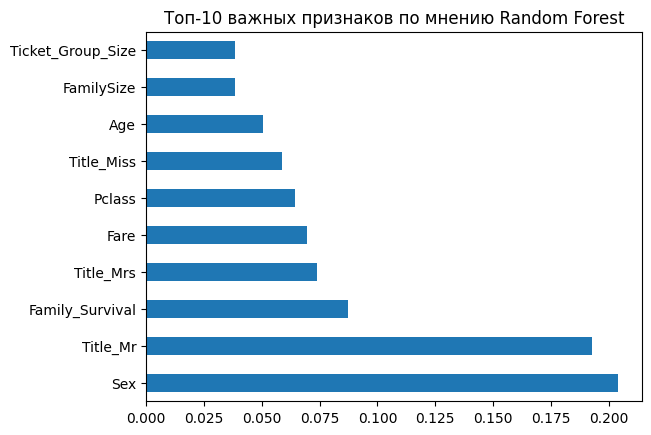

Text(50.722222222222214, 0.5, 'Actual')

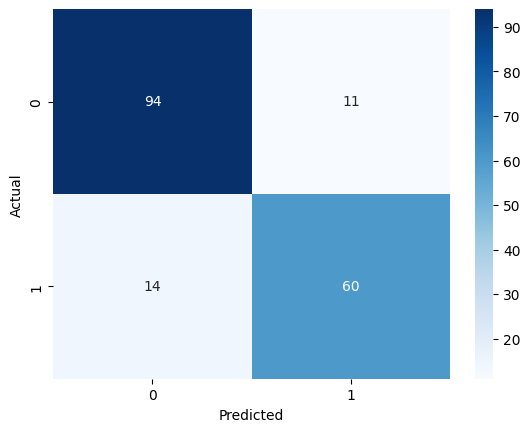

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
best_rf.fit(X_train, y_train)

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=True).head(40))
importances.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков по мнению Random Forest')
plt.show()

errors_df = val_df_raw.copy()
errors_df['Actual'] = val_df_raw['Survived']
errors_df['Predicted'] = final_model.predict(X_val)
errors = errors_df[errors_df['Actual'] != errors_df['Predicted']]
errors.head(10)

y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

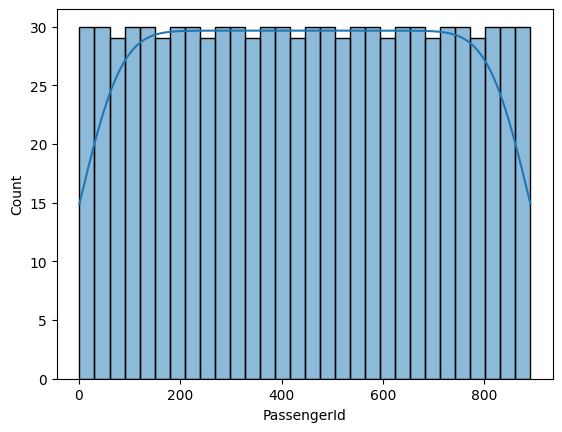

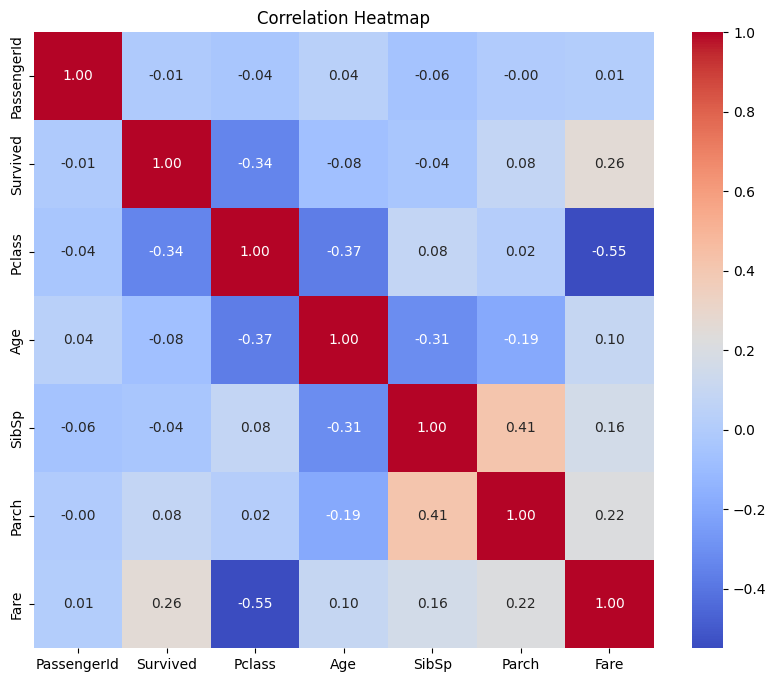

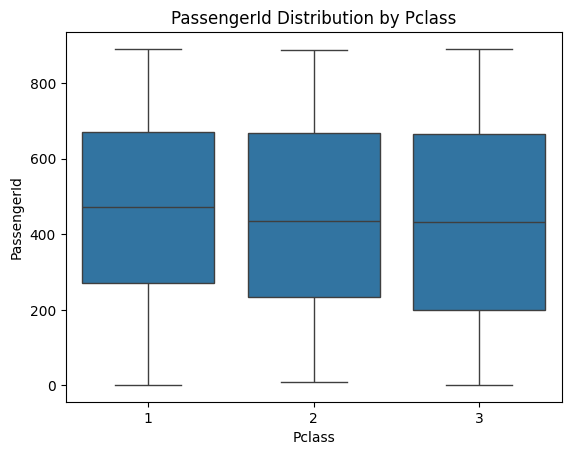

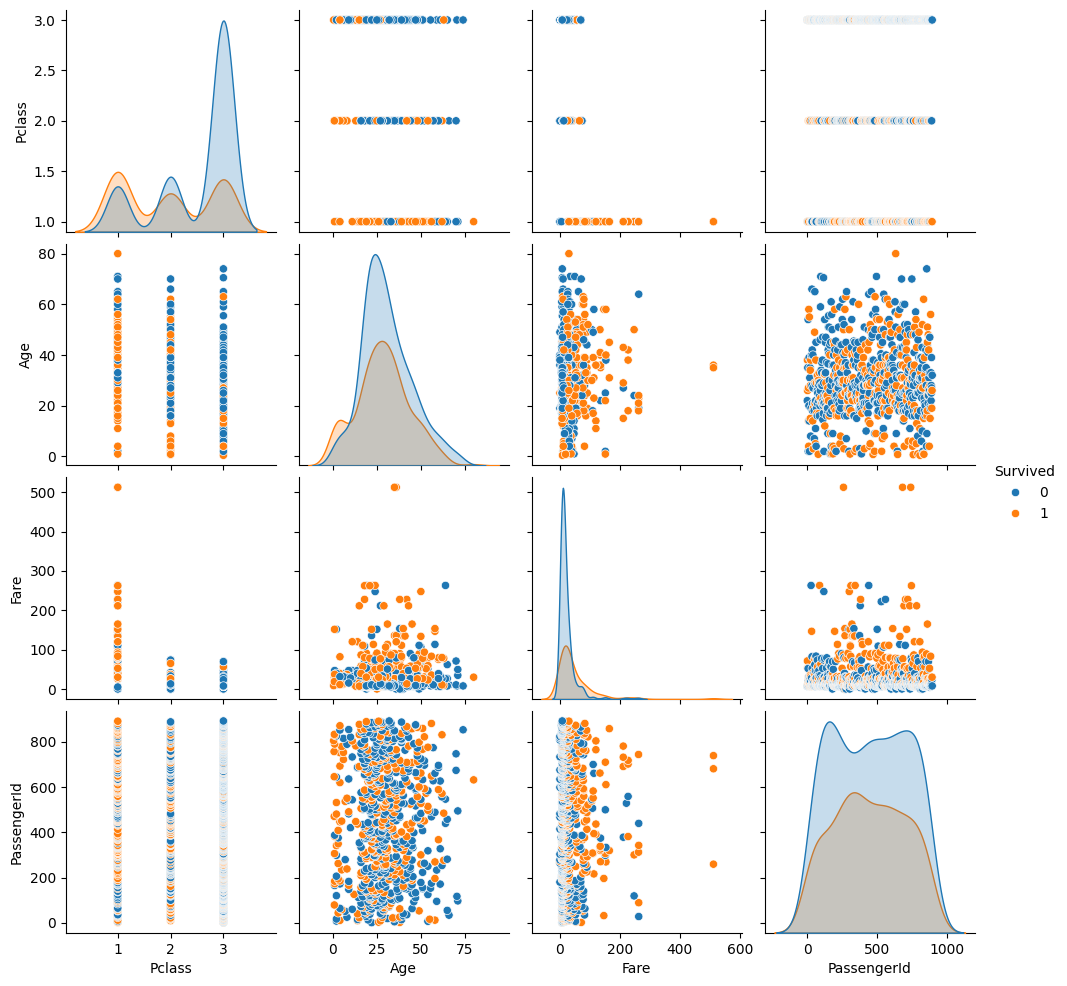

In [11]:
import pandas as pd
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=df, x='PassengerId', bins=30, kde=True)
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

sns.boxplot(data=df, x='Pclass', y='PassengerId')
plt.title('PassengerId Distribution by Pclass')
plt.show()

cols = ['Survived', 'Pclass', 'Age', 'Fare', 'PassengerId']
sns.pairplot(df[cols], hue='Survived', diag_kind='kde')
plt.show()